Training of RCNN model done in 3 stages
1. CNN finetuning
2. CNN + SVM
3. Bounding box regression



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
train_path = '/kaggle/input/rcnn-data-preprocessing-part-2/Train/'
test_path = '/kaggle/input/rcnn-data-preprocessing-part-2/Test/'

# Preparing The Data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = (224,224,3)

In [5]:
train_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_data = train_generator.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 subset='training')

val_data = train_generator.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 subset='validation')

test_generator  = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_directory(test_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",shuffle=False,
                                                 batch_size=BATCH_SIZE)

Found 42696 images belonging to 3 classes.
Found 10673 images belonging to 3 classes.
Found 16247 images belonging to 3 classes.


# Model Architecture

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=IMAGE_SIZE))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

for layer in baseModel.layers:
    layer.trainable = False

model = Model(inputs=baseModel.input, outputs=headModel)

opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

58892288/58889256 [==============================] - 1s 0us/step


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
early_stop = EarlyStopping(patience=2,monitor='val_loss')

# Training

In [10]:
results = model.fit_generator(train_data,epochs=20,
                              validation_data=val_data,
                             callbacks=[early_stop])

Epoch 1/20
668/668 [==============================] - 271s 406ms/step - loss: 0.3921 - accuracy: 0.9338 - val_loss: 0.1365 - val_accuracy: 0.9520
Epoch 2/20
668/668 [==============================] - 238s 356ms/step - loss: 0.1678 - accuracy: 0.9494 - val_loss: 0.1645 - val_accuracy: 0.9523
Epoch 3/20
668/668 [==============================] - 237s 354ms/step - loss: 0.1474 - accuracy: 0.9535 - val_loss: 0.1469 - val_accuracy: 0.9588


# Model evaluation

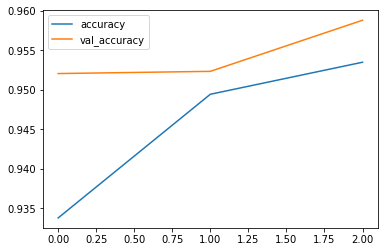

In [11]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()

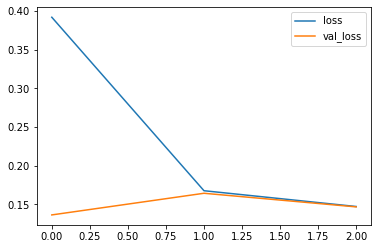

In [12]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [13]:
test_pred = model.predict_generator(test_data)

In [14]:
pred_class = [np.argmax(x) for x in test_pred]

In [15]:
test_data.class_indices

{'background': 0, 'crop': 1, 'weed': 2}

In [16]:
true_class = test_data.classes

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
print(classification_report(true_class,pred_class))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10769
           1       0.96      0.96      0.96      3147
           2       0.97      0.90      0.93      2331

    accuracy                           0.97     16247
   macro avg       0.97      0.95      0.96     16247
weighted avg       0.97      0.97      0.97     16247



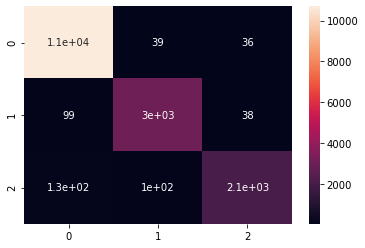

In [19]:
sns.heatmap(confusion_matrix(true_class,pred_class),annot=True)

# Predict on some test images

In [20]:
mapping_class = test_data.class_indices

In [21]:
mapping_class = dict([(value, key) for key, value in mapping_class.items()]) 

## Prediction on Batch

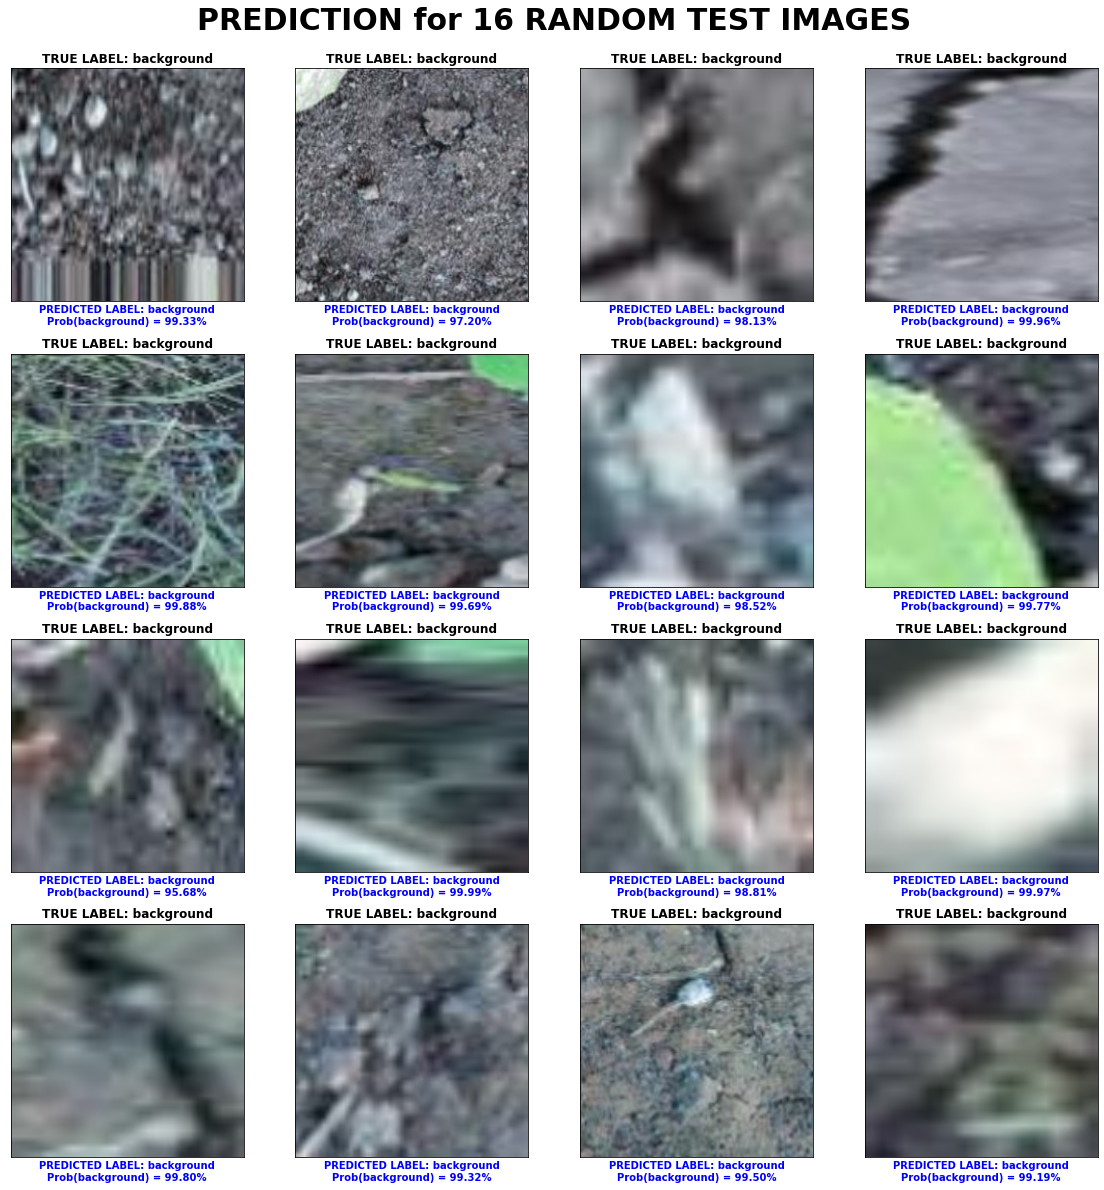

In [22]:
images, labels = next(iter(test_data))
images = images.reshape(64, 224,224,3)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images[:16], labels[:16]):
    ax.imshow(img)
    true_label = mapping_class[np.argmax(label)]
    
    pred_prob = model.predict(img.reshape(1, 224,224, 3))
    pred_label = mapping_class[np.argmax(pred_prob)]
    
    prob_class = np.max(pred_prob) * 100
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 12)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 10,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("PREDICTION for 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

## Missclassified Images

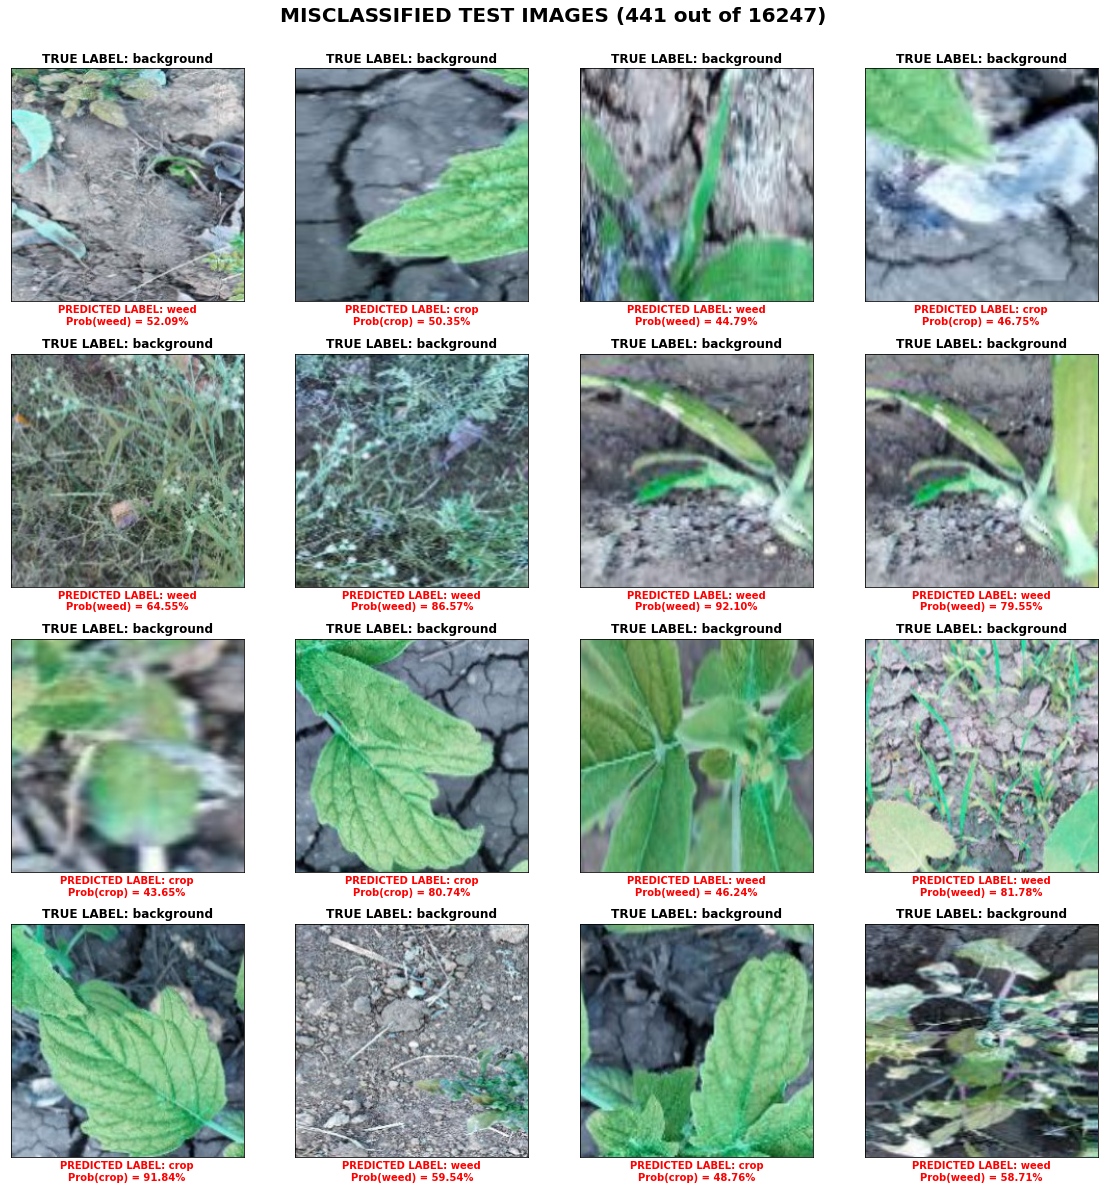

In [23]:

misclassify_pred = np.nonzero(true_class != pred_class)[0]
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    images, labels = test_data[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*IMAGE_SIZE))
    
    true_label = mapping_class[np.argmax(label)]
    
    pred_prob = model.predict(img.reshape(1, 224,224, 3))
    pred_label = mapping_class[np.argmax(pred_prob)]
    
    prob_class = np.max(pred_prob)*100
    
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 12)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 10,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()

# Saving model

In [24]:
model.save('RCNN_crop_weed_classification_model.h5')